<a href="https://colab.research.google.com/github/amarabuco/deeplearning-2024.2/blob/main/Aula_4_Arquiteturas_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Arquiteturas CNNs

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## MNIST

In [ ]:
trainset = torchvision.datasets.MNIST(root='./data', train=True,  transform=transform,
                                        download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

NameError: name 'transform' is not defined

In [ ]:
testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform,
                                       download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

In [ ]:
trainset.data[0].shape

torch.Size([28, 28])

In [ ]:
trainset.data.shape

torch.Size([60000, 28, 28])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

0 - zero  8 - eight  4 - four  6 - six


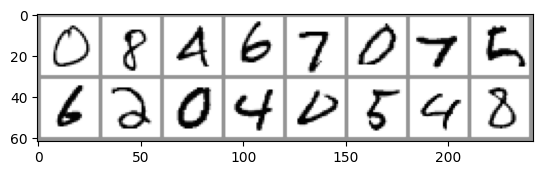

In [ ]:
# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(trainset.classes[labels[j]] for j in range(4)))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Lenet

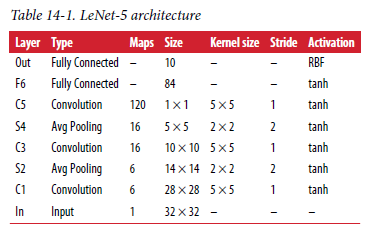

In [ ]:
class Lenet(nn.Module):
  def __init__(self):
    super(Lenet, self).__init__()
    self.c1 = torch.nn.Conv2d(1,6,5, padding=2)
    self.s2 = nn.AvgPool2d(2, stride=2)
    self.c3 = torch.nn.Conv2d(6,16,5)
    self.s4 = nn.AvgPool2d(2, stride=2)
    self.c5 = torch.nn.Conv2d(16,120,5)
    self.f6 = torch.nn.Linear(120, 84)
    self.out = torch.nn.Linear(84, 10)

  def forward(self, x):
    x = self.s2(F.tanh(self.c1(x)))
    x = self.s4(F.tanh(self.c3(x)))
    x = F.tanh(self.c5(x))
    x = x.view(-1, self.num_flat_features(x))
    x = F.tanh(self.f6(x))
    x = self.out(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

lenet = Lenet()
lenet.to(device)

Lenet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()

In [ ]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(lenet.parameters(), lr=0.001, momentum=0.9)

In [ ]:
loss_list = []
stop = 0
for epoch in range(3):
  running_loss = 0.0
  # if stop == 1:
  #   break

  for i, data in enumerate(trainloader, 0):

    # inputs, labels = data
    inputs, labels = data[0].to(device), data[1].to(device)
    # inputs = inputs.to(device)
    # labels = labels.to(device)

    optimizer.zero_grad()

    outputs = lenet(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 1999:
      loss_list.append(running_loss / 2000)
      print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0

    # if loss_list[-1] > loss_list[-2]:
    #   stop = 1
    #   break


print('Finished Training')

[1,  2000] loss: 0.993
[2,  2000] loss: 0.227
[3,  2000] loss: 0.135
Finished Training


In [ ]:
correct = 0
total = 0

with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        outputs = lenet(images) # calculate outputs by running images through the network

        _, predicted = torch.max(outputs.data, 1) # the class with the highest energy is what we choose as prediction
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 97 %


## Imagenet

https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageNet.html

In [ ]:
# !wget https://image-net.org/data/ILSVRC/2012/ILSVRC2012_devkit_t12.tar.gz -P ./data

--2024-09-03 20:32:04--  https://image-net.org/data/ILSVRC/2012/ILSVRC2012_devkit_t12.tar.gz
Resolving image-net.org (image-net.org)... 171.64.68.16
Connecting to image-net.org (image-net.org)|171.64.68.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2568145 (2.4M) [application/x-gzip]
Saving to: ‘./data/ILSVRC2012_devkit_t12.tar.gz.1’

ILSVRC2012_devkit_t 100%[===================>]   2.45M  1.75MB/s    in 1.4s    

2024-09-03 20:32:06 (1.75 MB/s) - ‘./data/ILSVRC2012_devkit_t12.tar.gz.1’ saved [2568145/2568145]



In [ ]:
# !wget https://image-net.org/data/ILSVRC/2012/ILSVRC2012_img_train.tar -P ./data


--2024-09-03 20:32:37--  https://image-net.org/data/ILSVRC/2012/ILSVRC2012_img_train.tar
Resolving image-net.org (image-net.org)... 171.64.68.16
Connecting to image-net.org (image-net.org)|171.64.68.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147897477120 (138G) [application/x-tar]
Saving to: ‘./data/ILSVRC2012_img_train.tar’

ILSVRC2012_img_trai   0%[                    ]  39.73M   714KB/s    eta 3d 7h  ^C


In [ ]:
#Imagenet é grande demais, Imagenette é um subset com 10 classes.
trainset = torchvision.datasets.Imagenette(root='./data', split="train", transform =transform,
                                         download=False)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

In [ ]:
testset = torchvision.datasets.Imagenette(root='./data', split="val", transform =transform,
                                       download=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=True, num_workers=2)

In [ ]:
trainset

Dataset Imagenette
    Number of datapoints: 9469
    Root location: ./data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

## AlexNet

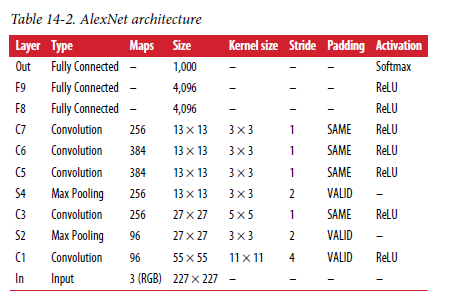

In [ ]:
class Alexnet(nn.Module):
  def __init__(self):
    super(Alexnet, self).__init__()
    self.c1 = torch.nn.Conv2d(3,96,11,stride=4, padding=3)
    # self.c1 = torch.nn.Conv2d(3,96,11,stride=4)
    self.s2 = nn.MaxPool2d(3, stride=2)
    self.c3 = torch.nn.Conv2d(96,256,5)
    self.s4 = nn.MaxPool2d(3, stride=2)
    self.c5 = torch.nn.Conv2d(256,384,3)
    self.c6 = torch.nn.Conv2d(384,384,3)
    self.c7 = torch.nn.Conv2d(384,256,3)
    self.fc8 = torch.nn.Linear(6400, 4096)
    self.fc9 = torch.nn.Linear(4096, 4096)
    self.out = torch.nn.Linear(4096, 10)

  def forward(self, x):
    x = self.s2(F.local_response_norm(F.relu(self.c1(x)), size=2, alpha=0.00002, beta=0.75, k=1.0))
    x = self.s4(F.local_response_norm(F.relu(self.c3(x)), size=2, alpha=0.00002, beta=0.75, k=1.0))
    x = F.relu(self.c5(x))
    x = F.relu(self.c6(x))
    x = F.relu(self.c7(x))
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc8(x))
    if self.training == True:
      x = F.dropout(x, p=0.5)
    x = F.relu(self.fc9(x))
    if self.training == True:
      x = F.dropout(x, p=0.5)
    x = F.softmax(self.out(x))
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

alexnet = Alexnet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
alexnet.to(device)

Alexnet(
  (c1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(3, 3))
  (s2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1))
  (s4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c5): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
  (c6): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1))
  (c7): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc8): Linear(in_features=6400, out_features=4096, bias=True)
  (fc9): Linear(in_features=4096, out_features=4096, bias=True)
  (out): Linear(in_features=4096, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(alexnet.parameters(), lr=0.02, momentum=0.9)

In [ ]:
import pandas as pd

In [ ]:
# @title Texto de título padrão
loss_list = []

for epoch in range(15):
  running_loss = 0.0

  for i, data in enumerate(trainloader):

    # inputs, labels = data[0].to(device), data[1].to(device)
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    # print(f"Batch {i+1}: First Input Value - {inputs[0][0][0][0].item()} First Label - {labels[0].item()} ")

    optimizer.zero_grad()

    outputs = alexnet(inputs)
    # print(outputs[0][0].item())
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    # print(running_loss)
    # print(running_loss)
    if i % 100 == 99:
      loss_list.append(running_loss / 100)
      print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
      running_loss = 0.0


print('Finished Training')

<ipython-input-47-e3085b329795>:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.out(x))


[1,   100] loss: 2.303
[1,   200] loss: 2.302
[2,   100] loss: 2.289
[2,   200] loss: 2.251
[3,   100] loss: 2.280
[3,   200] loss: 2.261
[4,   100] loss: 2.256
[4,   200] loss: 2.252
[5,   100] loss: 2.188
[5,   200] loss: 2.282
[6,   100] loss: 2.250
[6,   200] loss: 2.246
[7,   100] loss: 2.345
[7,   200] loss: 2.318
[8,   100] loss: 2.358
[8,   200] loss: 2.361
[9,   100] loss: 2.354
[9,   200] loss: 2.366
[10,   100] loss: 2.357
[10,   200] loss: 2.365
[11,   100] loss: 2.363
[11,   200] loss: 2.366
[12,   100] loss: 2.370
[12,   200] loss: 2.353
[13,   100] loss: 2.361
[13,   200] loss: 2.354
[14,   100] loss: 2.352
[14,   200] loss: 2.366
[15,   100] loss: 2.363
[15,   200] loss: 2.358
Finished Training


In [ ]:
correct = 0
total = 0

with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        outputs = alexnet(images) # calculate outputs by running images through the network

        _, predicted = torch.max(outputs.data, 1) # the class with the highest energy is what we choose as prediction
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

<ipython-input-47-e3085b329795>:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.out(x))


Accuracy of the network on the test images: 9 %


## GoogLeNet